In [78]:
import pandas as pd
import numpy as np

In [79]:
from xgboost import XGBRegressor
from xgboost import plot_importance, plot_tree
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import r2_score
from itertools import combinations

In [80]:
def generate_combinations(original_list):
    result = []
    for r in range(1, len(original_list) + 1):
        result.extend(combinations(original_list, r))
    return [list(combo) for combo in result]

In [81]:
df = pd.read_csv('GIV.csv', index_col = 'date')
df = df[['qty', 'price', 'Google_imm', 'lvmh_stock_price', 'kering_stock_price']]

In [82]:
# cols = list(df.columns)
# comb_cols = [cols[cols.index('qty')]]
# cols.remove('qty')

In [83]:
#generate_combinations(cols)        

In [84]:
print(list(df.columns))

['qty', 'price', 'Google_imm', 'leather_price', 'lvmh_stock_price', 'kering_stock_price']


In [85]:
df = df[['qty', 'price', 'Google_imm', 'lvmh_stock_price', 'kering_stock_price']] #'kering_stock_price'

In [86]:
future = 0
lag = 3
for col in df.columns:
    for i in range(future,lag):
        i = i + 1
        col_name = col+'-'+str(i)
        df[col+'-'+str(i)] = df[col].shift(i)
        df[col+'_V_'+str(i)] = (df[col] - df[col].shift(i)) / df[col].shift(i)
    if col != 'qty':
        df.drop(col, axis = 1, inplace = True)

In [87]:
df.index = pd.to_datetime(df.index)
df['date'] = df.index
df['month'] = df['date'].dt.month
df['month'].astype("category")
df['day'] = df['date'].dt.day
df['day'].astype("category")
df.set_index('date', drop = True, inplace = True)

In [88]:
#df.drop(df.columns[1:6], axis = 1, inplace = True)

In [89]:
df.dropna(inplace = True)

In [90]:
X = df[[col for col in df.columns if col != 'qty']] #df[cols_lag8]
y = df[['qty']]



In [91]:
xgb_model = XGBRegressor(verbosity = 0)
parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['reg:squarederror'],
              'learning_rate': [.03, 0.05, .07], #so called `eta` value
              'max_depth': [5, 6, 7],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [500]}

xgb = GridSearchCV(xgb_model, parameters, cv = 2, n_jobs = 5, verbose=True)


tscv = TimeSeriesSplit(n_splits=3)  

r2_values = []
rmse_values = []


for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    xgb.fit(X_train, y_train)
    
    y_pred = pd.DataFrame(xgb.predict(X_test), columns = ['qty'])

    y_pred = target_scaler.inverse_transform(y_pred)
    y_test = target_scaler.inverse_transform(y_test)
    
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = root_mean_squared_error(y_test, y_pred)
    r2_values.append(r2)
    rmse_values.append(rmse)
    print("R2:", r2)
    print("RMSE:", rmse)

    # plt.figure(figsize=(25, 12))
    # plt.plot(y_test.index, y_test, label='Actual')
    # plt.plot(y_test.index, y_pred, label='Predicted')
    # plt.xlabel('Time')
    # plt.ylabel('GIV')
    # plt.title('Actual vs Predicted GIV')
    # plt.legend()
    # plt.show()

# Average MSE across all folds
avg_r2 = np.mean(r2_values)
avg_rmse = np.mean(rmse_values)
print("Average RMSE:", avg_rmse)
print("Average R2:", avg_r2)

Fitting 2 folds for each of 9 candidates, totalling 18 fits
R2: 0.37974062519911556
RMSE: 240.18452343215094
Fitting 2 folds for each of 9 candidates, totalling 18 fits
R2: 0.4190072893784186
RMSE: 155.81337899517348
Fitting 2 folds for each of 9 candidates, totalling 18 fits
R2: 0.6639451374878607
RMSE: 153.7679139815929
Average RMSE: 183.25527213630576
Average R2: 0.487564350688465


In [92]:
df[['qty']].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
qty,147.0,927.927498,301.176135,323.330545,736.690812,939.953915,1102.819451,1818.179561


In [93]:
print("MODEL RMSE/M:", avg_rmse/df[['qty']].mean())

MODEL RMSE/M: qty    0.197489
dtype: float64


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

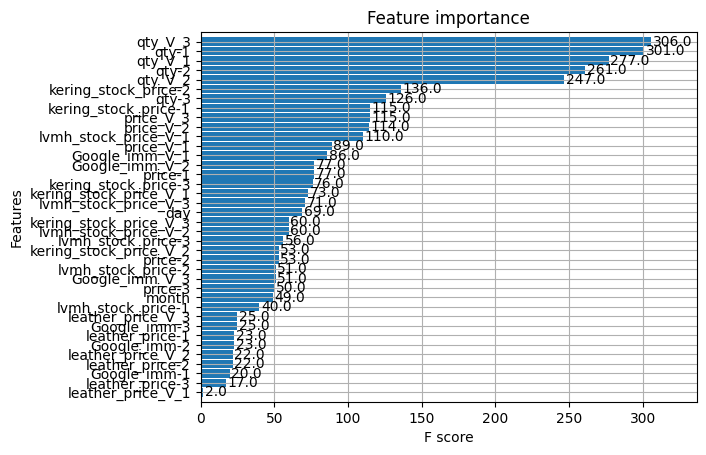

In [94]:
plot_importance(xgb.best_estimator_, height=0.9)